# Finetuning Script for ManuAI

This python notebook is responsible for the LoRA finetuning of ManuAI: NZ Bird Call Classifier.

The dataset used for training is a large collection of mel-spectrograms within their respective subfolder "spectrograms/{bird_name}" which we can obtain as the labels of the data.
The model we are finetuning is the "google/vit-base-patch16-224" model from the transformers library on HuggingFace

In [11]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import (
    CenterCrop,
    Resize,
    ToTensor,
    Normalize,
    Compose,
    RandomHorizontalFlip,
    RandomResizedCrop
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
# Load the dataset
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load spectrogram image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[idx]

def load_spectrogram_data(data_dir="spectrograms"):
    """
    Load spectrogram images from folder structure: spectrograms/{bird_name}/*.png
    Returns: image_paths, labels, label_encoder
    """
    image_paths = []
    labels = []
    
    # Get all bird species folders
    bird_species = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')]
    
    print(f"Found {len(bird_species)} bird species:")
    
    # Load all spectrogram files
    for bird_name in bird_species:
        bird_folder = os.path.join(data_dir, bird_name)
        
        # Get all image files (png, jpg, jpeg)
        image_files = [f for f in os.listdir(bird_folder) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"{bird_name}: {len(image_files)} spectrograms")
        
        for image_file in image_files:
            image_path = os.path.join(bird_folder, image_file)
            image_paths.append(image_path)
            labels.append(bird_name)
    
    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    print(f"\nTotal dataset: {len(image_paths)} spectrograms across {len(bird_species)} species")
    
    return image_paths, encoded_labels, label_encoder

# Define transforms for ViT (224x224 input size)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),  # Light augmentation for spectrograms
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data
image_paths, labels, label_encoder = load_spectrogram_data("spectrograms")

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples") 
print(f"Test: {len(X_test)} samples")

# Create datasets
train_dataset = SpectrogramDataset(X_train, y_train, transform=transform_train)
val_dataset = SpectrogramDataset(X_val, y_val, transform=transform_val)
test_dataset = SpectrogramDataset(X_test, y_test, transform=transform_val)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Class names: {list(label_encoder.classes_)}")

Found 10 bird species:
  - fantail
  - tomtit
  - whitehead
  - silvereye
  - tui
  - saddleback
  - morepork
  - bellbird
  - kaka
  - robin
fantail: 10 spectrograms
tomtit: 10 spectrograms
whitehead: 10 spectrograms
silvereye: 10 spectrograms
tui: 10 spectrograms
saddleback: 10 spectrograms
morepork: 10 spectrograms
bellbird: 10 spectrograms
kaka: 10 spectrograms
robin: 10 spectrograms

Total dataset: 100 spectrograms across 10 species
Train: 70 samples
Validation: 15 samples
Test: 15 samples
Number of classes: 10
Class names:
  - bellbird
  - fantail
  - kaka
  - morepork
  - robin
  - saddleback
  - silvereye
  - tomtit
  - tui
  - whitehead


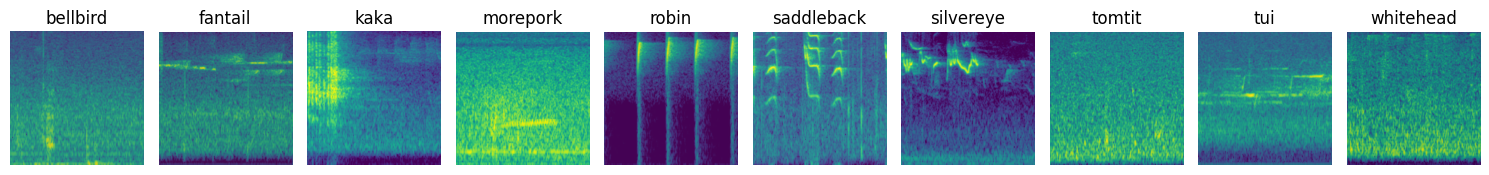

In [5]:
# Show image from each class of training set
def show_sample_images(dataset, num_classes=5):
    class_indices = np.unique(dataset.labels)
    plt.figure(figsize=(15, 10))
    
    for i, class_idx in enumerate(class_indices[:num_classes]):
        class_images = [dataset[i][0] for i in range(len(dataset)) if dataset.labels[i] == class_idx]
        if class_images:
            img = class_images[0].permute(1, 2, 0).numpy()  # Convert to HWC format
            img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Denormalize
            img = np.clip(img, 0, 1)  # Ensure valid pixel range
            plt.subplot(1, num_classes, i + 1)
            plt.imshow(img)
            plt.title(label_encoder.classes_[class_idx])
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, num_classes=10)  # Show first 10 classes

In [ ]:
model_name = "google/vit-base-patch16-224-in21k" # or "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

def process_image(image):
    """
    Process a single image for ViT model
    """
    inputs = processor(images=image, return_tensors="pt")
    return inputs

def transform(images):
    """
    Apply transformations to a batch of images
    """
    inputs = processor(images=images, return_tensors="pt")
    inputs['labels'] = torch.tensor([label_encoder.transform([label])[0] for label in labels])
    return inputs


array(['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback',
       'silvereye', 'tomtit', 'tui', 'whitehead'], dtype='<U10')